In [65]:
# Importing libraries #
import re, string
import nltk
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sn
import language_tool_python
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from textacy import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

tool = language_tool_python.LanguageTool('es-US')
stemmer = SnowballStemmer('spanish')

In [2]:
# Deifining key functions #

# Preprocessing paragraphs #

def process_paragraph(paragraph):
    """
    This function removes non representative string characters
    input: paragraph extracted from plain text file
    output: paragraph withoput stopwords and punctuation
    """

    # Function for data cleaning #
    def text_cleaning(text_to_clean):
        """
        This function cleans the text data
         """
        text_to_clean = preprocessing.remove.punctuation(text_to_clean)
        text_to_clean = preprocessing.remove.accents(text_to_clean)
        text_to_clean = preprocessing.normalize.whitespace(text_to_clean)
        text_to_clean = preprocessing.normalize.unicode(text_to_clean)
        return text_to_clean
    
    # Function for removing stopwords #
    def stopword(string):
        a = [i for i in string.split() if i not in stopwords.words('spanish')]
        return ' '.join(a)

    # Stemming the paragraph #
    def stemming(text_to_process):
        return ' '.join([ stemmer.stem(i) for i in text_to_process.split() ])

    # Correcting the input pragraph #
    new_paragraph =  stemming(stopword(text_cleaning(tool.correct(paragraph))))

    return new_paragraph

# Testing of functions #
test_paragraph = 'imienlo de dichas areas y la financiacion de los csquemas de pago por servicios ambientales _ lo anterior significa que el hecho que el predio que se restituye el reposo} cumo lo informo corpouraba, se localiza en la ronda hidrica del rio lcon. adcmas que el area que estc ocupa esta establecido como limite dc los humcdales del rio leon y quc segun el pot del municipio dc chigorodo define el area que ocupa este terreno como de preservacion y prolcccion amb'
print(process_paragraph(test_paragraph))

imitenl dich are financiacion esquem pag servici ambiental anterior signif hech predi restitu repos inform corporal localiz rond hidric rio adem are ocup establec limit dc humedal rio leon segun municipi dc vigor defin are ocup terren preservacion produccion acb


In [3]:
# Working with the data of decision #
df_decision = pd.read_csv("resources/list decision.csv")
df_decision["Sentencia_cleaned"] = df_decision["Sentencia"].apply(lambda x: process_paragraph(x))
df_decision.head()

,Sentencia,label,Sentencia_cleaned
0,imienlo de dichas areas y la financiacion de l...,1,imitenl dich are financiacion esquem pag servi...
1,abrir un nuevo folio de matricula inmobiliaria...,0,abrir nuev foli matricul inmobiliari vei j dej...
2,al predio restituido se debera brindar segurid...,0,al predi restitu deber brind segur presenci pe...
3,mobiliaria: la esterlina (008-11695): las dali...,0,mobiliari esterlin 008 11695 dali 2 008 11172 ...
4,folio 15 reverso; cuaderno no. 001_ tribunal s...,0,foli 15 revers cuadern 001 tribunal superior d...


In [106]:
# Modeling #

# Splitting train data and test data 0.4 #
X_train, X_test, y_train, y_test = train_test_split(df_decision['Sentencia_cleaned'].astype(str), df_decision['label'], test_size=0.4, shuffle=True, random_state=42)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), use_idf=True, max_features=300)

X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Para prediccion #
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [67]:
# Creating the model #
# TODO NOLOSE #
model = lgb.LGBMClassifier(max_bin=3,
                        max_depth=5,
                        lambda_l2=15,
                        num_leaves=6,
                        min_child_samples=10,
                        subsample=0.3,
                        colsample_bytree=0.5,
                        reg_alpha=1,
                        reg_lambda=10)

# Fitting the model to the tfidf vectors #
model.fit(X_train_vectors_tfidf, y_train)

# Estimating model accuracy #
y_pred = model.predict(X_test_vectors_tfidf)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

y_pred_train = model.predict(X_train_vectors_tfidf)
print("Training Accuracy:", metrics.accuracy_score(y_train, y_pred_train))

print("Distribucion del dataset:"+ '\n',df_decision["label"].value_counts())

[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=10 will be ignored. Current value: lambda_l2=15
Accuracy: 0.8375209380234506
Training Accuracy: 0.8747203579418344
Distribucion del dataset:
 0    1202
1     289
Name: label, dtype: int64


In [107]:
# Creating the model #
model = lgb.LGBMClassifier(max_bin=3,
                        max_depth=5,
                        lambda_l2=15,
                        num_leaves=6,
                        min_child_samples=10,
                        subsample=0.3,
                        colsample_bytree=0.5,
                        reg_alpha=1,
                        reg_lambda=10)

# Fitting the model to the tfidf vectors #
model.fit(X_train_vectors_tfidf, y_train)

# Estimating model accuracy #
y_pred = model.predict(X_test_vectors_tfidf)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

y_pred_train = model.predict(X_train_vectors_tfidf)
print("Training Accuracy:", metrics.accuracy_score(y_train, y_pred_train))

y_pred_proba = model.predict_proba(X_test_vectors_tfidf)

print("Distribucion del dataset:"+ '\n',df_decision["label"].value_counts())

[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=10 will be ignored. Current value: lambda_l2=15
Accuracy: 0.8375209380234506
Training Accuracy: 0.8747203579418344
Distribucion del dataset:
 0    1202
1     289
Name: label, dtype: int64


In [73]:
# Saving the pickle file #

# Saving the model #
filename = 'fitted_model_decision.sav'
pickle.dump(model, open(filename, 'wb'))

# Testing the model #
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_vectors_tfidf, y_test)
print(result)

# # Saving the vectors for testing #
# file = open('variables_decision.txt', 'w')
# pickle.dump(str(X_test_vectors_tfidf), file)
# file.close()
 


0.8375209380234506


In [39]:
# Testing the xgboost classifier for unbalanced classes
from xgboost import XGBClassifier

model_xgboost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_xgboost.fit(X_train_vectors_tfidf, y_train)

y_pred_xgb = model_xgboost.predict(X_test_vectors_tfidf)
print("Accuracy xgboost:", metrics.accuracy_score(y_test, y_pred_xgb))

Accuracy xgboost: 0.8107202680067002


C:\Users\Martin V\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


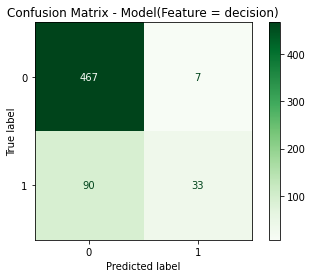

In [100]:
# Grafica de una matriz de confusion #

metrics.plot_confusion_matrix(model, X_test_vectors_tfidf, y_test, cmap='Greens')
plt.title('Confusion Matrix - Model(Feature = decision)')
plt.show()

In [98]:
# Rebalanceo utilizando smote #
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Starting the sampling methods #

#Oversampling label1 with 30%#
over = SMOTE(sampling_strategy=0.25)

#Undersampling label 0 with 45%
under = RandomUnderSampler(sampling_strategy=0.4)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transforming the dataset with the pipeline #
X_smoted, Y_smoted = pipeline.fit_resample(X_train_vectors_tfidf, y_train)
#model.fit(X_smoted, Y_smoted)
y_pred_smoted = model.predict(X_smoted)
print(metrics.accuracy_score(y_test,y_pred_smoted))

# Ploting the confusion matrix #
metrics.plot_confusion_matrix(model, X_test_vectors_tfidf, y_test)
plt.title('Confusion Matrix - Model output (Feature = sentido decision)')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [597, 637]

In [58]:
oversampled_df = df_decision.copy()
max_class_size = np.max(oversampled_df['label'].value_counts())
print('Size of biggest class: ', max_class_size)

class_subsets = [oversampled_df.query('label == ' + str(i)) for i in range(2)] # range(2) because it is a binary class

for i in range(2):
  class_subsets[i] = class_subsets[i].sample(max_class_size,random_state=42,replace=True)

oversampled_df = pd.concat(class_subsets,axis=0).sample(frac=1.0,random_state=42).reset_index(drop=True)
print(oversampled_df["label"].value_counts())
print(len( oversampled_df["Sentencia"] ))
print(oversampled_df.info())
oversampled_df.head()



Size of biggest class:  1202
0    1202
1    1202
Name: label, dtype: int64
2404
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2404 entries, 0 to 2403
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Sentencia          2404 non-null   object
 1   label              2404 non-null   int64 
 2   Sentencia_cleaned  2404 non-null   object
dtypes: int64(1), object(2)
memory usage: 56.5+ KB
None


,Sentencia,label,Sentencia_cleaned
0,"folio 522 529 , en el cual se solicita reconoc...",0,foli 522 529 solicit reconoc senor hortensi ch...
1,especializado en restitucion de tierras de pop...,1,especializ restitucion tierr popay call 2 nro ...
2,onas indeterminadas que se consideraran afecta...,0,onas indetermin consider afect decision tom pr...
3,013121002-2014-0072-00 encuentra ubicado en el...,0,013121002 2014 0072 00 encuentr ubic municipi ...
4,es en la vereda ia secreta en octubre del año ...,0,es vered secret octubr ano 1998 qued comprob d...


[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=10 will be ignored. Current value: lambda_l2=15
Accuracy Oversampled: 0.8076923076923077
Accuracy Original: 0.8375209380234506


C:\Users\Martin V\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


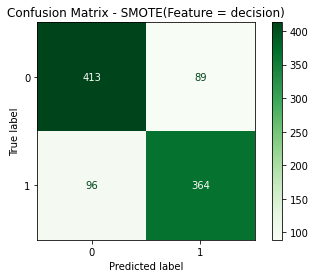

In [102]:
# Modeling #

# Splitting train data and test data 0.4 #
X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(oversampled_df['Sentencia_cleaned'].astype(str), oversampled_df['label'], test_size=0.4, shuffle=True, random_state=42)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), use_idf=True, max_features=300)

X_train_vectors_tfidf_oversampled = tfidf_vectorizer.fit_transform(X_train_oversampled)

# Para prediccion #
X_test_vectors_tfidf_oversampled = tfidf_vectorizer.transform(X_test_oversampled)

# Fitting the model to the tfidf vectors #
model.fit(X_train_vectors_tfidf_oversampled, y_train_oversampled)

# Estimating model accuracy #
y_pred_oversampled = model.predict(X_test_vectors_tfidf_oversampled)
print("Accuracy Oversampled:", metrics.accuracy_score(y_test_oversampled, y_pred_oversampled))

print("Accuracy Original:", metrics.accuracy_score(y_test, y_pred))

metrics.plot_confusion_matrix(model, X_test_vectors_tfidf_oversampled, y_test_oversampled, cmap='Greens')
plt.title('Confusion Matrix - SMOTE(Feature = decision)')
plt.show()


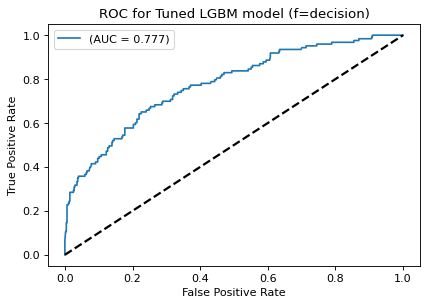

In [108]:
y_pred_proba = model.predict_proba(X_test_vectors_tfidf)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
auc = metrics.auc(fpr,tpr)
plt.figure(figsize=(6,4), dpi=80)
plt.plot(fpr,tpr,label="(AUC = {0:0.3f})".format(auc),)
plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.title("ROC for Tuned LGBM model (f=decision)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [42]:
test_df = pd.read_csv("resources/list_to_test.csv")
test_input = test_df["Sentencia"].apply(lambda x: process_paragraph(x))
test_input = tfidf_vectorizer.fit_transform(test_input)

# usar predict proba # .targe value_counts() 0 y 1
test_pred = model.predict_proba(test_input)
print(test_pred)

[[0.88207091 0.11792909]
 [0.77143014 0.22856986]
 [0.92364371 0.07635629]
 ...
 [0.91612967 0.08387033]
 [0.89313755 0.10686245]
 [0.93499537 0.06500463]]


In [40]:
print(type(test_pred), np.shape(test_pred))

<class 'numpy.ndarray'> (511, 2)


In [37]:
def find_top5(vector):
    ind = np.argpartition(vector[:,1], -4)[-4:]
    proba = vector[:,1][ind]
    return  proba

def print_values(proba):
    for i in proba:
        print('Probability =',proba[i])

In [51]:
# Retrieving the top 5 higher probabilities #

#Retrieving the index in the vector 2nd column (positive value)
ind = np.argpartition(test_pred[:,1], -6)[-6:]
print('Index for top 5:',ind)

# Retrieving the value of the index found earlier #
probability = test_pred[:,1][ind]
print('Probability for top 5:', probability)

Index for top 5: [247 243 266 254 261 265]
Probability for top 5: [0.48028561 0.62052826 0.54807249 0.57581812 0.58860914 0.61026377]


In [75]:
# Exporting arrays for ROC Plotter #
arr = np.asarray ( y_test )
arr_proba = np.asarray ( y_pred_proba[:,1] )
#print(arr)
arr.tofile('modelGraphData/data_model_decision_yTest.csv', sep=',')
arr_proba.tofile('modelGraphData/data_model_decision_yProba.csv', sep=',')

In [25]:
# Queda por implementar una matriz de confusion para validar el rendimiento #
# Mirar como usar el modelo de forma facil para implementarlo en backend #
# Si se retorna un 0 en el array de vectores se confirma que se puede extraer el feature.#
#Configurar el retorno de la funcion #

#Parrafo -> predict clase -> predict proba confianza del modelo (0.8) - mostrar todos los parrafos para doc.
# quedarme con el top 5 DONE
# iperparameter tuning #
# igbm desbalanceado y tecnicas de balance (2) tecnica smout, f1, precision #
# xgboost xgboost is_unbalanced = True. (1) #
# indice | Texto sin preprocesar en la vecindad de la palabra | Texo preprocesado | 

511
